<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [28]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [2]:
data = pd.read_csv('./train.csv')

In [3]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

Посмотрим на первые пять строк

In [4]:
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


Проверим незаполненные значения. Таковых нет

In [5]:
data.isna().values.any()

False

Так как в дальнейшем при построении гистограммы было замечено, что числовая колонка TotalSpent не является таковой рассмотрим её тип и пустые значения

In [6]:
data['TotalSpent'].dtypes

dtype('O')

In [7]:
data[data['TotalSpent'].str.isspace()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


Поменяем пустые значения на нули и поменяем тип колонки на флоат

In [8]:
transformed_data = data.copy()
transformed_data['TotalSpent'] = data['TotalSpent'].replace(r'\s+', '0', regex=True)
transformed_data['TotalSpent'] = pd.to_numeric(transformed_data['TotalSpent'], downcast="float")

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

Разделим датафрейм на два: категориальный и числовой

In [9]:
numeric_data = transformed_data[num_cols]
categorical_data = transformed_data[cat_cols]

numeric_data.head()

,ClientPeriod,MonthlySpending,TotalSpent
0,55,19.50,1026.349976
1,72,25.85,1872.199951
2,1,75.90,75.900002
3,32,79.30,2570.000000
4,60,115.25,6758.450195


Построим гистограмму числовых признаков

array([[<AxesSubplot:title={'center':'ClientPeriod'}>,
        <AxesSubplot:title={'center':'MonthlySpending'}>],
       [<AxesSubplot:title={'center':'TotalSpent'}>, <AxesSubplot:>]],
      dtype=object)

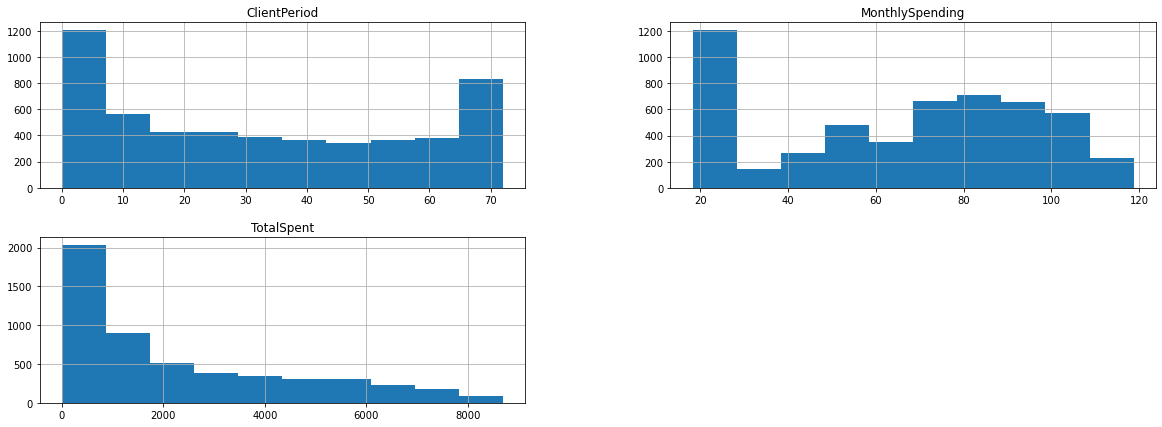

In [10]:
numeric_data.hist(figsize=(20, 7))

Для каждой колонки категориальных признаков посчитаем value_counts и построим bar диаграммы

<ipython-input-11-23a0b67e6386>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(value_col.index, rotation = 30)
<ipython-input-11-23a0b67e6386>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


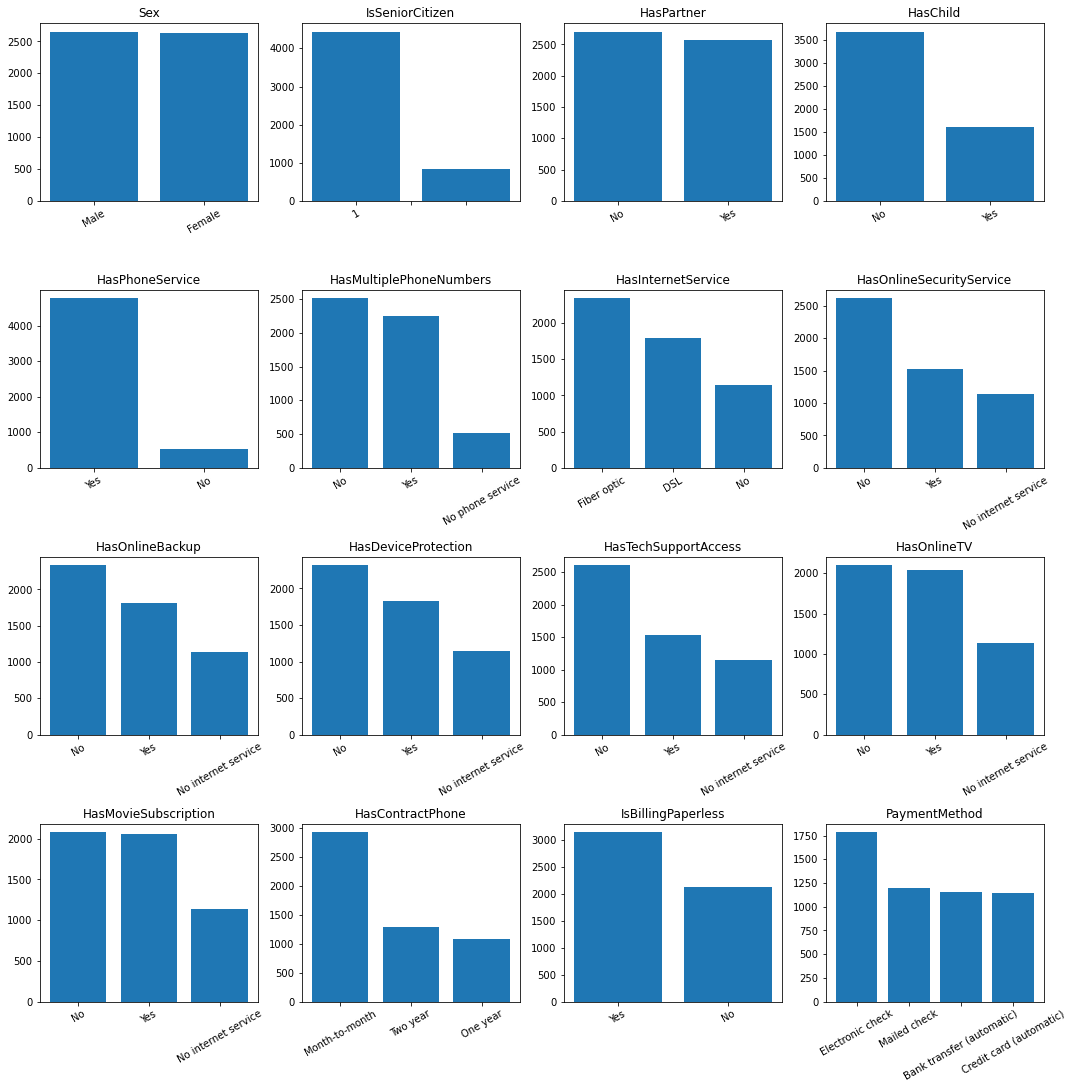

In [11]:
fig, ax = plt.subplots(4, 4, figsize=(18,18))
ax = ax.ravel()

for i, name_col in enumerate(cat_cols):
  ax[i].set_title(name_col)
  value_col = transformed_data[name_col].value_counts()
  ax[i].bar(value_col.index, value_col.values)
  ax[i].set_xticklabels(value_col.index, rotation = 30)

plt.subplots_adjust(hspace = 0.5)
fig.show()

Посмотрим на распределение целевой переменной

<BarContainer object of 2 artists>

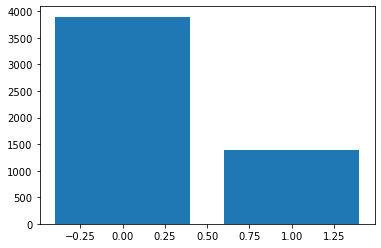

In [12]:
value_col = transformed_data[target_col].value_counts()
plt.bar(value_col.index, value_col.values)

Наблюдается дисбаланс классов целевой переменной больше чем в половину. Следовательно метрикой accuracy пользоваться не стоит

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

In [13]:
# YOUR CODE

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [14]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

Создадим ColumnTransformer с отнормированными числовыми и закодироваными категориальными колонками для дальнейшего его применения в pipeline 

In [15]:
from sklearn.compose import ColumnTransformer
columnTransformer = ColumnTransformer(
    transformers=[
        ('num_cols', StandardScaler(), num_cols),
        ('cat_cols', OneHotEncoder(), cat_cols)
    ])

Создадим один общий pipeline путем объединения ColumnTransformer для преобразования данных и LogisticRegression

In [16]:
pipeline = make_pipeline(columnTransformer, LogisticRegression())

Проверим список параметров которые можно подбирать

In [17]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'logisticregression', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__num_cols', 'columntransformer__cat_cols', 'columntransformer__num_cols__copy', 'columntransformer__num_cols__with_mean', 'columntransformer__num_cols__with_std', 'columntransformer__cat_cols__categories', 'columntransformer__cat_cols__drop', 'columntransformer__cat_cols__dtype', 'columntransformer__cat_cols__handle_unknown', 'columntransformer__cat_cols__sparse', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalt

Разделим тренировочные данные

In [18]:
X_train = transformed_data.drop([target_col], axis=1)
y_train = transformed_data[target_col]

Подберем лучшие параметры при помощи GridSearchCV

In [19]:
param_grid = [
    {
        'logisticregression__C': [100, 10, 1, 0.1, 0.01, 0.001]
    }
]
grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc')
grid_search.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_cols',
                                                                         StandardScaler(),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending',
                                                                          'TotalSpent']),
                                                                        ('cat_cols',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'IsSeniorCitizen',
                                                                          'HasPartner',
                                                     

Лучшие параметры

In [20]:
grid_search.best_params_

{'logisticregression__C': 100}

Лучшее качество

In [21]:
grid_search.best_score_

0.8451148504343466

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [24]:
#!pip install catboost
import catboost

Разделим данные на тренировочные и тестовые

In [22]:
X_train_origin, X_test_origin, y_train_origin, y_test_origin = train_test_split(
                                                       X_train.values, 
                                                       y_train.values, 
                                                       train_size=0.8, 
                                                       random_state=42)

Создадим контейнер с набором данных для бустинга

In [25]:
catboost_pool = catboost.Pool(
                  data=X_train_origin,
                  label=y_train_origin,
                  cat_features=cat_cols,
                  feature_names=list(X_train.columns))

Обучим модель на стандартных параметрах

In [26]:
boosting_model = catboost.CatBoostClassifier()

boosting_model.fit(catboost_pool)

y_train_predicted = boosting_model.predict_proba(X_train_origin)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test_origin)[:, 1]

Learning rate set to 0.019062
0:	learn: 0.6798227	total: 211ms	remaining: 3m 30s
1:	learn: 0.6678084	total: 233ms	remaining: 1m 56s
2:	learn: 0.6553003	total: 269ms	remaining: 1m 29s
3:	learn: 0.6435910	total: 346ms	remaining: 1m 26s
4:	learn: 0.6326850	total: 377ms	remaining: 1m 14s
5:	learn: 0.6225823	total: 416ms	remaining: 1m 8s
6:	learn: 0.6128742	total: 453ms	remaining: 1m 4s
7:	learn: 0.6048572	total: 473ms	remaining: 58.7s
8:	learn: 0.5958847	total: 500ms	remaining: 55.1s
9:	learn: 0.5871696	total: 537ms	remaining: 53.2s
10:	learn: 0.5792007	total: 597ms	remaining: 53.7s
11:	learn: 0.5713099	total: 683ms	remaining: 56.3s
12:	learn: 0.5643834	total: 746ms	remaining: 56.6s
13:	learn: 0.5569418	total: 849ms	remaining: 59.8s
14:	learn: 0.5502712	total: 891ms	remaining: 58.5s
15:	learn: 0.5441586	total: 1s	remaining: 1m 1s
16:	learn: 0.5381109	total: 1.03s	remaining: 59.6s
17:	learn: 0.5324322	total: 1.1s	remaining: 1m
18:	learn: 0.5268003	total: 1.14s	remaining: 59s
19:	learn: 0.52

Узнаем score после применения бустинга

In [29]:
y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
train_searching_auc = roc_auc_score(y_train, y_train_predicted)
train_searching_auc

0.8836923003348389

Теперь проведем подбор наилучших параметров

In [30]:
catboost_train_dataset = catboost.Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_cols,
                  feature_names=list(X_train.columns))

searching_model = catboost.CatBoostClassifier(loss_function='Logloss')

grid = {
        "iterations": [100, 200, 300],
        "learning_rate": [0.03, 0.1, 0.15, 0.2, 0.3]
}

grid_search_result = searching_model.grid_search(grid, X=catboost_train_dataset)

0:	learn: 0.6764019	test: 0.6751493	best: 0.6751493 (0)	total: 33.1ms	remaining: 3.28s
1:	learn: 0.6617112	test: 0.6595627	best: 0.6595627 (1)	total: 56.5ms	remaining: 2.77s
2:	learn: 0.6478898	test: 0.6448169	best: 0.6448169 (2)	total: 110ms	remaining: 3.55s
3:	learn: 0.6342666	test: 0.6298840	best: 0.6298840 (3)	total: 152ms	remaining: 3.66s
4:	learn: 0.6222754	test: 0.6169738	best: 0.6169738 (4)	total: 222ms	remaining: 4.22s
5:	learn: 0.6107325	test: 0.6046623	best: 0.6046623 (5)	total: 245ms	remaining: 3.84s
6:	learn: 0.5998068	test: 0.5930194	best: 0.5930194 (6)	total: 292ms	remaining: 3.88s
7:	learn: 0.5890812	test: 0.5815027	best: 0.5815027 (7)	total: 344ms	remaining: 3.96s
8:	learn: 0.5794342	test: 0.5717631	best: 0.5717631 (8)	total: 391ms	remaining: 3.95s
9:	learn: 0.5701473	test: 0.5619793	best: 0.5619793 (9)	total: 415ms	remaining: 3.73s
10:	learn: 0.5643757	test: 0.5554829	best: 0.5554829 (10)	total: 456ms	remaining: 3.69s
11:	learn: 0.5569474	test: 0.5473226	best: 0.54732

Лучшие параметры

In [31]:
grid_search_result['params']

{'iterations': 200, 'learning_rate': 0.1}

Лучшее качество

In [32]:
y_train_predicted = searching_model.predict_proba(X_train)[:, 1]
train_searching_auc = roc_auc_score(y_train, y_train_predicted)
train_searching_auc

0.893363778519887

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

# Предсказания

In [33]:
best_model = searching_model

Подготовим тестовые данные также, как это делали для тренировочных

In [34]:
test_data = pd.read_csv('./test.csv')

In [35]:
test_data.isna().values.any()

False

In [36]:
test_data['TotalSpent'].dtypes

dtype('O')

In [38]:
test_data[test_data['TotalSpent'].str.isspace()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
177,0,19.85,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
767,0,20.25,,Male,0,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check


In [39]:
X_test = test_data.copy()
X_test['TotalSpent'] = test_data['TotalSpent'].replace(r'\s+', '0', regex=True)
X_test['TotalSpent'] = pd.to_numeric(X_test['TotalSpent'], downcast="float")

score 0.85 на kaggle

In [40]:
y_test_predicted = searching_model.predict_proba(X_test)[:, 1]

submission = pd.read_csv('./submission.csv', index_col=0)
submission['Churn'] = y_test_predicted
submission.to_csv('./my_submission.csv')

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.